In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
scheduler_df = pd.read_csv('data/scheduler_data.csv')

# Filter relevant columns and remove rows with missing time data
scheduler_df_filtered = scheduler_df[['cpus_req', 'nodes_alloc', 'gres_req', 'time_start', 'time_end']]
scheduler_df_filtered = scheduler_df_filtered.dropna(subset=['time_start', 'time_end'])

# Calculate job duration
scheduler_df_filtered['job_duration'] = scheduler_df_filtered['time_end'] - scheduler_df_filtered['time_start']

# Parse 'gres_req' to extract GPU count information
def parse_gpu_count(gres):
    if pd.isnull(gres):
        return 0
    if 'gpu' in gres:
        return int(gres.split(':')[-1])
    return 0

scheduler_df_filtered['gpu_count'] = scheduler_df_filtered['gres_req'].apply(parse_gpu_count)

# Feature engineering: Job intensity as a weighted sum of requested CPUs, nodes, and GPUs
scheduler_df_filtered['job_intensity'] = scheduler_df_filtered['cpus_req'] + scheduler_df_filtered['nodes_alloc'] * 2 + scheduler_df_filtered['gpu_count'] * 4

# Drop unnecessary columns
scheduler_df_final = scheduler_df_filtered.drop(columns=['gres_req'])

# Split the data into features (X) and target (y)
X = scheduler_df_final[['cpus_req', 'nodes_alloc', 'gpu_count', 'job_intensity']]
y = scheduler_df_final['job_duration']

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
lr_rmse = mean_squared_error(y_test, y_pred_lr, squared=False)
lr_r2 = r2_score(y_test, y_pred_lr)

# 2. Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_rmse = mean_squared_error(y_test, y_pred_rf, squared=False)
rf_r2 = r2_score(y_test, y_pred_rf)

# Print evaluation metrics
print(f"Linear Regression RMSE: {lr_rmse}, R²: {lr_r2}")
print(f"Random Forest RMSE: {rf_rmse}, R²: {rf_r2}")


Linear Regression RMSE: 3540917.096841388, R²: 0.3756164557561218
Random Forest RMSE: 1841474.919695957, R²: 0.8311303716368725


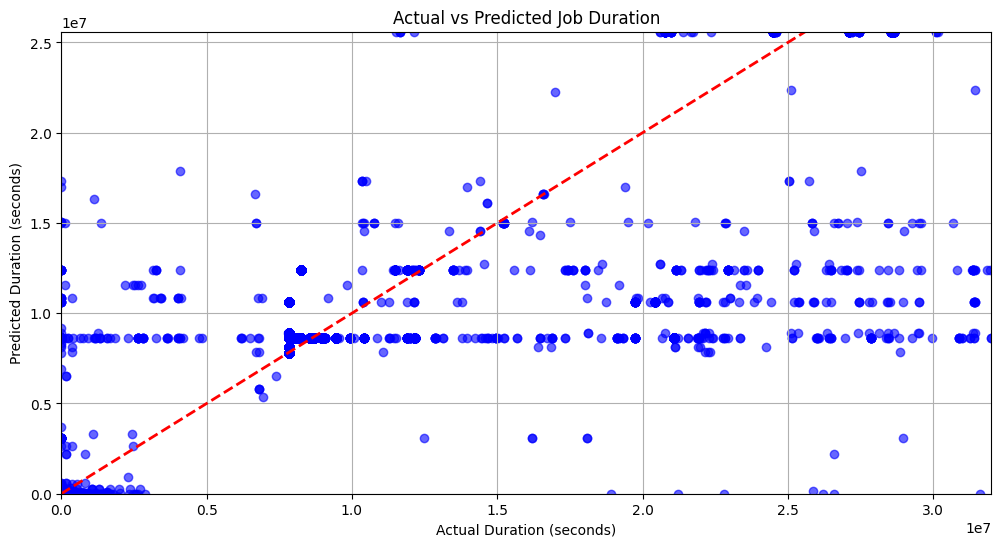

In [3]:
import matplotlib.pyplot as plt

# Combining actual and predicted values into a DataFrame
results_df = pd.DataFrame({
    'Actual Duration': y_test,
    'Predicted Duration': y_pred_rf  # Using Random Forest predictions
})

# Plotting Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.scatter(results_df['Actual Duration'], results_df['Predicted Duration'], alpha=0.6, color='b')
plt.plot([0, max(results_df['Actual Duration'])], [0, max(results_df['Actual Duration'])], 'r--', linewidth=2)  # 45-degree line
plt.title('Actual vs Predicted Job Duration')
plt.xlabel('Actual Duration (seconds)')
plt.ylabel('Predicted Duration (seconds)')
plt.xlim(0, max(results_df['Actual Duration']))
plt.ylim(0, max(results_df['Predicted Duration']))
plt.grid()
plt.show()


In [4]:
# Combining actual and predicted values into a DataFrame
results_df = pd.DataFrame({
    'Actual Duration': y_test,
    'Predicted Duration': y_pred_rf  # Using Random Forest predictions
})

# Resetting index for better display
results_df.reset_index(drop=True, inplace=True)

# Displaying the table
print(results_df.head(10))  # Print the first 10 rows for brevity


   Actual Duration  Predicted Duration
0            53341        1.389723e+04
1          7950538        8.629897e+06
2          8980908        8.629897e+06
3                0       -4.802689e-01
4               98       -4.802689e-01
5             7646       -2.028958e+05
6           346634       -3.660857e+04
7          8981061        8.629897e+06
8           129678       -4.165829e+04
9              437       -4.802689e-01


In [5]:
# Convert predicted durations to integer for better readability
results_df['Predicted Duration'] = results_df['Predicted Duration'].round(0).astype(int)

# Display the updated table
print(results_df.head(10))


   Actual Duration  Predicted Duration
0            53341               13897
1          7950538             8629897
2          8980908             8629897
3                0                   0
4               98                   0
5             7646             -202896
6           346634              -36609
7          8981061             8629897
8           129678              -41658
9              437                   0
